In [ ]:
# Note
# We do not have the exact model we had when we submitted our best public score, but this is fairly similar
# The penultimate code block contains the training loop, and when run, four separate models should appear

In [1]:
!pip install --user xgboost
import xgboost
import pandas as pd
from datetime import datetime

import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
df = pd.read_csv("./train.csv", error_bad_lines=False, engine="python")                                                                                                                                    
df

cuda


/tmp/ipykernel_738/1310086275.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("./train.csv", error_bad_lines=False, engine="python")


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


In [5]:
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

df[["YR", "MON", "DAY", "HR", "WK"]] = df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
# df = df.drop(columns=['ORIGIN_CALL', 'DAY_TYPE','TRIP_ID']) 
df = df[df.get('MISSING_DATA') == False] 


def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 1, 0) * 15

df["trip_time"] = df["POLYLINE"].apply(polyline_to_trip_duration)

df

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time
0,C,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345
1,B,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285
2,C,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975
3,C,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645
4,C,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435
...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,C,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",2014,6,30,23,0,480
1710666,C,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",2014,6,30,23,0,450
1710667,C,NaN,20000264,1388745716,False,[],2014,1,3,10,4,0
1710668,B,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",2014,6,30,15,0,930


In [6]:
origin_df = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')

In [7]:
df = df[df.get('trip_time') > 0]

df

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time
0,C,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345
1,B,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285
2,C,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975
3,C,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645
4,C,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435
...,...,...,...,...,...,...,...,...,...,...,...,...
1710663,C,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2014,1,2,11,3,2910
1710665,C,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",2014,6,30,23,0,480
1710666,C,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",2014,6,30,23,0,450
1710668,B,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",2014,6,30,15,0,930


In [8]:
# def new_parse_stand(dataframe):
#     longitudes = []
#     latitudes = []
#     areas = []
#     for i in range(len(dataframe)):
#         polyline = dataframe['POLYLINE']
#         coords = polyline.values[i].split("],[")
#         init_coord = coords[0]
#         print(init_coord)
#         longitude = ''
#         latitude = ''
#         if(init_coord == '41.163066654-8.67598304213'):
#             longitude = '41.163066654'
#             latitude = '-8.67598304213'
#         longitude = init_coord.split(',')[0][2:]
#         latitude = init_coord.split(',')[1]
#         area = ''
#         origin = dataframe['ORIGIN_STAND'].values[i]
#         if (int(origin) > 0):
#             area = ((origin_df.iloc[int(origin) - 1].values[1]))
#         area = 'NA'
#         longitudes.append(float(longitude))
#         latitudes.append(float(latitude))
#         areas.append(area)
#     dataframe['Latitude'] = latitudes
#     dataframe['Longitude'] = longitudes
#     dataframe['Area'] = areas

#     return longitudes, latitudes, areas

import ast
def parse_stand(df):
    def extract_coordinate(polyline):
        coordinate = ast.literal_eval(polyline)[0]
        return float(coordinate[0]), float(coordinate[1])

    for index, row in df.iterrows():
        origin_stand = row['ORIGIN_STAND']
        if 'POLYLINE' not in row.index:
            if origin_stand == -100:
                continue
            else:
                origin = origin_stand
                area = origin_df.iloc[int(origin) - 1, 1]
                int1, int2 = origin_df.iloc[int(origin) - 1, 2:4]
                if int1 == '41.163066654-8.67598304213':
                    int1, int2 = '41.163066654', '-8.67598304213'
                df.at[index, 'Latitude'] = float(int1)
                df.at[index, 'Longitude'] = float(int2) 
                continue
                
        
        polyline = row['POLYLINE']
        
        if origin_stand == -100:
            if polyline:
                latitude, longitude = extract_coordinate(polyline)
                df.at[index, 'Latitude'] = latitude
                df.at[index, 'Longitude'] = longitude
        else:
            origin = origin_stand
            area = origin_df.iloc[int(origin) - 1, 1]
            int1, int2 = origin_df.iloc[int(origin) - 1, 2:4]
            if int1 == '41.163066654-8.67598304213':
                int1, int2 = '41.163066654', '-8.67598304213'
            df.at[index, 'Latitude'] = float(int1)
            df.at[index, 'Longitude'] = float(int2)

    return df

In [9]:
df

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time
0,C,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345
1,B,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285
2,C,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975
3,C,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645
4,C,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435
...,...,...,...,...,...,...,...,...,...,...,...,...
1710663,C,NaN,20000585,1388660427,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2014,1,2,11,3,2910
1710665,C,NaN,20000698,1404171463,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",2014,6,30,23,0,480
1710666,C,NaN,20000670,1404171367,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",2014,6,30,23,0,450
1710668,B,12.0,20000248,1404141826,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",2014,6,30,15,0,930


In [10]:
# get rid of NaN values and one-hot encode CALL_TYPE
df['ORIGIN_STAND'].fillna(-100, inplace=True)
# longitudes, latitudes, areas = new_parse_stand(df)
df = parse_stand(df)
# perform one-hot encoding
one_hot = pd.get_dummies(df['CALL_TYPE'])

# concatenate the one-hot encoded dataframe with the original dataframe
df = pd.concat([df, one_hot], axis=1)
df['MISSING_DATA'] = 0
df

/tmp/ipykernel_738/1530996535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ORIGIN_STAND'].fillna(-100, inplace=True)
/tmp/ipykernel_738/933323472.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'Latitude'] = latitude
/tmp/ipykernel_738/933323472.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time,Latitude,Longitude,A,B,C
0,C,-100.0,20000589,1372636858,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345,-8.618643,41.141412,0,0,1
1,B,7.0,20000596,1372637303,0,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285,41.159980,-8.641984,0,1,0
2,C,-100.0,20000320,1372636951,0,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975,-8.612964,41.140359,0,0,1
3,C,-100.0,20000520,1372636854,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645,-8.574678,41.151951,0,0,1
4,C,-100.0,20000337,1372637091,0,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435,-8.645994,41.180490,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710663,C,-100.0,20000585,1388660427,0,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2014,1,2,11,3,2910,-8.606970,41.162283,0,0,1
1710665,C,-100.0,20000698,1404171463,0,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",2014,6,30,23,0,480,-8.612469,41.146020,0,0,1
1710666,C,-100.0,20000670,1404171367,0,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",2014,6,30,23,0,450,-8.610138,41.140845,0,0,1
1710668,B,12.0,20000248,1404141826,0,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",2014,6,30,15,0,930,41.155120,-8.630466,0,1,0


In [12]:
from pandas.core.groupby.generic import DataFrame
from sklearn.preprocessing import LabelEncoder
df = df.loc[df['POLYLINE'].apply(lambda x: max(x.count("[") - 1, 0) > 0)]
df['TAXI_ID'] = df['TAXI_ID'] - 20000000 
df

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time,Latitude,Longitude,A,B,C
0,C,-100.0,-19999411,1372636858,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345,-8.618643,41.141412,0,0,1
1,B,7.0,-19999404,1372637303,0,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285,41.159980,-8.641984,0,1,0
2,C,-100.0,-19999680,1372636951,0,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975,-8.612964,41.140359,0,0,1
3,C,-100.0,-19999480,1372636854,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645,-8.574678,41.151951,0,0,1
4,C,-100.0,-19999663,1372637091,0,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435,-8.645994,41.180490,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710663,C,-100.0,-19999415,1388660427,0,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2014,1,2,11,3,2910,-8.606970,41.162283,0,0,1
1710665,C,-100.0,-19999302,1404171463,0,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",2014,6,30,23,0,480,-8.612469,41.146020,0,0,1
1710666,C,-100.0,-19999330,1404171367,0,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",2014,6,30,23,0,450,-8.610138,41.140845,0,0,1
1710668,B,12.0,-19999752,1404141826,0,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",2014,6,30,15,0,930,41.155120,-8.630466,0,1,0


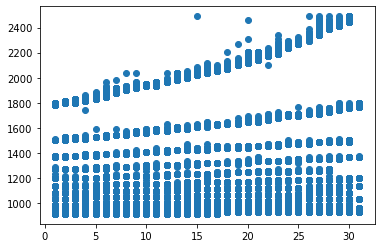

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

underDf = df[df.get("trip_time") <= 900]
overDf = df[(df.get("trip_time") > 900) & (df.get("trip_time") < 2500)]

y = overDf['trip_time']
y = y.sort_values()
import matplotlib.pyplot as plt
x = overDf['DAY']
plt.scatter(x.values, y.values)

currDf shape: 318637


/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


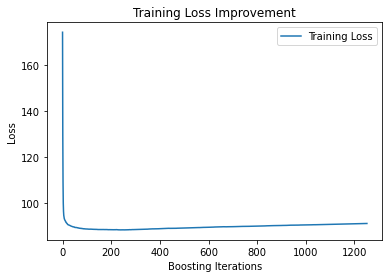

XGB Mean squared error for bin$(0, 360): 7792.24
currDf shape: 987216


/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


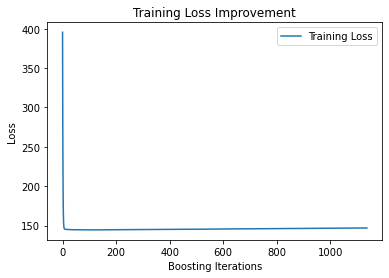

XGB Mean squared error for bin$(360, 900): 20849.40
currDf shape: 307907


/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


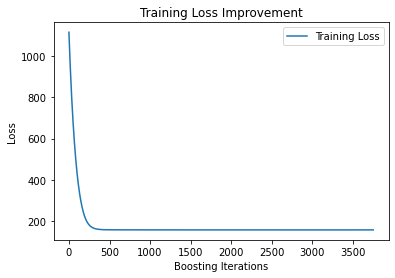

XGB Mean squared error for bin$(900, 1500): 24470.38
currDf shape: 50200


/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sil045/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


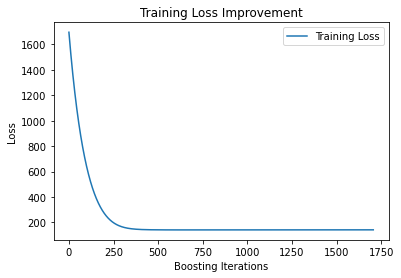

XGB Mean squared error for bin$(1500, 2000): 19986.64


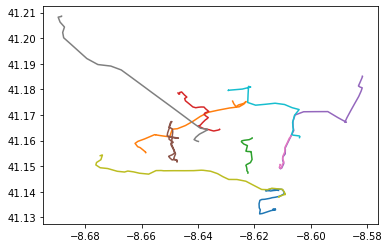

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

bins = [(0, 360, 0.4, 200), (360, 900, 0.4, 200), (900, 1500,0.01, 200), (1500, 2000, 0.01, 200)]

dictOne, dictTwo, dictThree, dictFour, dictFive, dictSix = {}, {}, {}, {}, {}, {}
index = 0

# for question 2 on milestone
differences = []

# Code to generate heatmap - ignore for training and testing
# import seaborn as sns
# head_df = df[(df.get('Latitude') != -1) & (df.get('Longitude') != -1)]
# print(head_df.shape[0])
# # Create a heatmap using seaborn
# sns.set(style="darkgrid")
# plt.figure(figsize=(10, 8))
# sns.kdeplot(x=head_df['Longitude'], y=head_df['Latitude'], shade=True, cmap='viridis')

# # Set the labels and title of the plot
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Distribution of Trip Positions')

# # Display the heatmap
# plt.show()

for index, (lower, upper, lr, offset) in enumerate(bins):
    #generate dataframe
    currDf = df[(df.get("trip_time") > lower) & (df.get("trip_time") <= upper)]
    #generate training data
    curr_X = currDf.drop(["trip_time", "TIMESTAMP", "ORIGIN_STAND", "MISSING_DATA", "CALL_TYPE", "POLYLINE"], axis=1)
    curr_y = currDf["trip_time"]
    curr_X_train, curr_X_val, curr_y_train, curr_y_val = train_test_split(curr_X, curr_y, test_size=0.05, random_state=42)

    print("currDf shape:", currDf.shape[0])

    columns_to_scale = ["TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "Latitude", "Longitude", "A", "B", "C"]

    scaler = StandardScaler()
    scaler.fit(curr_X_train[columns_to_scale])

    curr_X_train_scaled = curr_X_train.copy()
    curr_X_val_scaled = curr_X_val.copy()
    curr_X_train_scaled[columns_to_scale] = scaler.transform(curr_X_train[columns_to_scale])
    curr_X_val_scaled[columns_to_scale] = scaler.transform(curr_X_val[columns_to_scale])
    

    eval_set = [(curr_X_val_scaled, curr_y_val)]
    model = XGBRegressor(n_estimators=5000, learning_rate=lr, max_depth=7, random_state=42, reg_alpha=1, reg_lambda=1)

    # Fit the model on the training data
    model.fit(curr_X_train_scaled, curr_y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=1000, verbose=False)
    filename = 'model' + str(index)
    file_extension = 'model'
    file_path = f"{filename}.{file_extension}"
    model.save_model(file_path)
    
    # Get the evaluation results
    eval_results = model.evals_result()

    # Extract the training loss values
    plt.plot(eval_results['validation_0']['rmse'], label='Training Loss')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Improvement')
    plt.legend()
    plt.show()

    # Make predictions on the validation set
    y_pred = model.predict(curr_X_val_scaled)

    # Calculate the mean squared error
    mse = mean_squared_error(curr_y_val, y_pred)
    print(f"XGB Mean squared error for bin${(lower,upper)}: {mse:.2f}")
    num_predictions = len(curr_y_val)
    for i in range(num_predictions):
        differences.append(y_pred[i] - curr_y_val.values[i])

    # testing predictions
    modelOut = pd.read_csv('680_score.csv')
    newdf =  modelOut[(modelOut.get("TRAVEL_TIME") > lower - offset) & (modelOut.get("TRAVEL_TIME") <= upper + offset)]
    
    test_df = pd.read_csv('test_public.csv')
    mergedUnderDf = test_df.merge(newdf, left_on='TRIP_ID', right_on='TRIP_ID')
    test_df = mergedUnderDf
    
    test_df[["YR", "MON", "DAY", "HR", "WK"]] = test_df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
    
    test_df['ORIGIN_STAND'].fillna(15.0, inplace=True)
    test_df = parse_stand(test_df)
    test_df['TAXI_ID'] = test_df['TAXI_ID'] - 20000000 
    # perform one-hot encoding
    one_hot = pd.get_dummies(test_df['CALL_TYPE'])
    # concatenate the one-hot encoded dataframe with the original dataframe
    test_df['A'] = 0
    test_df['B'] = 0
    test_df['C'] = 0
    
    if('A' in one_hot.columns):
        test_df['A'] = one_hot['A']
    if('B' in one_hot.columns):
        test_df['B'] = one_hot['B']
    if('C' in one_hot.columns):
        test_df['C'] = one_hot['C']

    tripidSeriesUnder = test_df.get('TRIP_ID')

    # Define a list of columns to be scaled
    columns_to_scale = ["TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "A", "B", "C", "Latitude", "Longitude"]

    X_test = test_df.drop(["CALL_TYPE",'ORIGIN_CALL', 'DAY_TYPE', 'TRIP_ID', "TIMESTAMP", "ORIGIN_STAND", "MISSING_DATA", "TRAVEL_TIME"], axis=1)
    X_test_scaled = X_test.copy()
    # Create a scaler object and fit it on the training data
    scaler.fit(test_df[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


    y_pred_under = model.predict(X_test_scaled)


    for i, val in enumerate(tripidSeriesUnder.values):
        if(index == 0):
            dictOne[val] = y_pred_under[i]
        elif(index == 1):
            dictTwo[val] = y_pred_under[i]
        elif(index == 2):
            dictThree[val] = y_pred_under[i]
        elif(index == 3):
            dictFour[val] = y_pred_under[i]
        elif(index == 4):
            dictFive[val] = y_pred_under[i]
        else:
            dictSix[val] = y_pred_under[i]
    
    index += 1

top_loss_indices = np.argsort(differences)[::-1][:10]
top_samples = df['POLYLINE'].iloc[top_loss_indices]
fig, ax = plt.subplots()
for i in range(len(top_samples)):
    polyline = top_samples.values[i]
    coords = polyline.split("],[")
    coords[0] = coords[0][2:]
    coords[-1] = coords[-1][:-2]
    longitudes = []
    latitudes = []
    for coord in coords:
        coordinate = coord.split(",")
        longitudes.append(float(coordinate[0]))
        latitudes.append(float(coordinate[1]))
    ax.plot(longitudes, latitudes)

In [ ]:
import re
import pandas as pd

# Combine the dictionaries and average values for duplicate keys
combined_dict = {}
all_dicts = [dictOne, dictTwo, dictThree, dictFour, dictFive, dictSix]

for dictionary in all_dicts:
    for key, value in dictionary.items():
        if key in combined_dict:
            combined_dict[key].append(value)
        else:
            combined_dict[key] = [value]

for key, values in combined_dict.items():
    average_value = sum(values) / len(values)
    combined_dict[key] = average_value

# Extract the numeric part from the keys and sort based on numeric value
sorted_keys = sorted(combined_dict.keys(), key=lambda x: int(x[1:]))

# Create a pandas Series with the sorted keys and values
s = pd.Series([combined_dict[k] for k in sorted_keys], index=sorted_keys)

print(s)

# Creating the DataFrame
data = {
    'TRIP_ID': s.index,
    'TRAVEL_TIME': s.values
}
submit_df = pd.DataFrame(data)

# Saving the DataFrame as a CSV file
submit_df.to_csv('myPreds.csv', index=False)